# Self made SVD

In [1]:
import helpers
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from collections import defaultdict
from itertools import chain
import random

train_read=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None)
test_read=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)
train_ui, test_ui, user_code_id, user_id_code, item_code_id, item_id_code = helpers.data_to_csr(train_read, test_read)

In [2]:
# Done similarly to https://github.com/albertauyeung/matrix-factorization-in-python
from tqdm import tqdm

class SVD():
    
    def __init__(self, train_ui, learning_rate, regularization, nb_factors, iterations):
        self.train_ui=train_ui
        self.uir=list(zip(*[train_ui.nonzero()[0],train_ui.nonzero()[1], train_ui.data]))
        
        self.learning_rate=learning_rate
        self.regularization=regularization
        self.iterations=iterations
        self.nb_users, self.nb_items=train_ui.shape
        self.nb_ratings=train_ui.nnz
        self.nb_factors=nb_factors
        
        self.Pu=np.random.normal(loc=0, scale=1./self.nb_factors, size=(self.nb_users, self.nb_factors))
        self.Qi=np.random.normal(loc=0, scale=1./self.nb_factors, size=(self.nb_items, self.nb_factors))

    def train(self, test_ui=None):
        if test_ui!=None:
            self.test_uir=list(zip(*[test_ui.nonzero()[0],test_ui.nonzero()[1], test_ui.data]))
            
        self.learning_process=[]
        pbar = tqdm(range(self.iterations))
        for i in pbar:
            pbar.set_description(f'Epoch {i} RMSE: {self.learning_process[-1][1] if i>0 else 0}. Training epoch {i+1}...')
            np.random.shuffle(self.uir)
            self.sgd(self.uir)
            if test_ui==None:
                self.learning_process.append([i+1, self.RMSE_total(self.uir)])
            else:
                self.learning_process.append([i+1, self.RMSE_total(self.uir), self.RMSE_total(self.test_uir)])
    
    def sgd(self, uir):
        
        for u, i, score in uir:
            # Computer prediction and error
            prediction = self.get_rating(u,i)
            e = (score - prediction)
            
            # Update user and item latent feature matrices
            Pu_update=self.learning_rate * (e * self.Qi[i] - self.regularization * self.Pu[u])
            Qi_update=self.learning_rate * (e * self.Pu[u] - self.regularization * self.Qi[i])
            
            self.Pu[u] += Pu_update
            self.Qi[i] += Qi_update
        
    def get_rating(self, u, i):
        prediction = self.Pu[u].dot(self.Qi[i].T)
        return prediction
    
    def RMSE_total(self, uir):
        RMSE=0
        for u,i, score in uir:
            prediction = self.get_rating(u,i)
            RMSE+=(score - prediction)**2
        return np.sqrt(RMSE/len(uir))
    
    def estimations(self):
        self.estimations=\
        np.dot(self.Pu,self.Qi.T)

    def recommend(self, user_code_id, item_code_id, topK=10):
        
        top_k = defaultdict(list)
        for nb_user, user in enumerate(self.estimations):
            
            user_rated=self.train_ui.indices[self.train_ui.indptr[nb_user]:self.train_ui.indptr[nb_user+1]]
            for item, score in enumerate(user):
                if item not in user_rated and not np.isnan(score):
                    top_k[user_code_id[nb_user]].append((item_code_id[item], score))
        result=[]
        # Let's choose k best items in the format: (user, item1, score1, item2, score2, ...)
        for uid, item_scores in top_k.items():
            item_scores.sort(key=lambda x: x[1], reverse=True)
            result.append([uid]+list(chain(*item_scores[:topK])))
        return result
    
    def estimate(self, user_code_id, item_code_id, test_ui):
        result=[]
        for user, item in zip(*test_ui.nonzero()):
            result.append([user_code_id[user], item_code_id[item], 
                           self.estimations[user,item] if not np.isnan(self.estimations[user,item]) else 1])
        return result

In [3]:
model=SVD(train_ui, learning_rate=0.005, regularization=0.02, nb_factors=100, iterations=40)
model.train(test_ui)

Epoch 39 RMSE: 0.7467772350811145. Training epoch 40...: 100%|██████████| 40/40 [00:59<00:00,  1.50s/it]


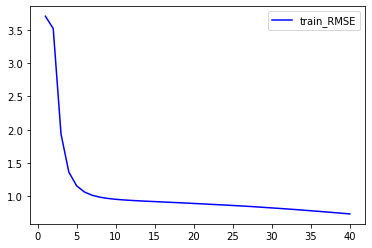

In [4]:
import matplotlib.pyplot as plt

df=pd.DataFrame(model.learning_process).iloc[:,:2]
df.columns=['epoch', 'train_RMSE']
plt.plot('epoch', 'train_RMSE', data=df, color='blue')
plt.legend()

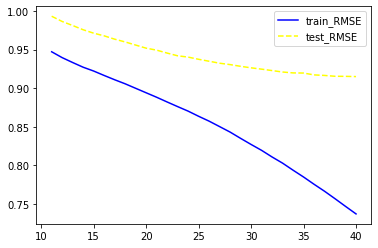

In [5]:
import matplotlib.pyplot as plt

df=pd.DataFrame(model.learning_process[10:], columns=['epoch', 'train_RMSE', 'test_RMSE'])
plt.plot('epoch', 'train_RMSE', data=df, color='blue')
plt.plot('epoch', 'test_RMSE', data=df, color='yellow', linestyle='dashed')
plt.legend()

#### Saving and evaluating recommendations

In [6]:
model.estimations()

top_n=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))

top_n.to_csv('Recommendations generated/ml-100k/Self_SVD_reco.csv', index=False, header=False)

estimations=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations.to_csv('Recommendations generated/ml-100k/Self_SVD_estimations.csv', index=False, header=False)

In [7]:
import evaluation_measures as ev

estimations_df=pd.read_csv('Recommendations generated/ml-100k/Self_SVD_estimations.csv', header=None)
reco=np.loadtxt('Recommendations generated/ml-100k/Self_SVD_reco.csv', delimiter=',')

ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=reco,
            super_reactions=[4,5])

943it [00:00, 9025.30it/s]


RMSE      MAE  precision    recall       F_1      F_05  \
0  0.915079  0.71824   0.104772  0.045496  0.054393  0.071374   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.094421      0.076826  0.109517  0.052005  0.206646  0.519484   

         HR       HR2  Reco in test  Test coverage   Shannon      Gini  
0  0.487805  0.264051      0.874549       0.142136  3.890472  0.972126

In [8]:
import imp
imp.reload(ev)

import evaluation_measures as ev
dir_path="Recommendations generated/ml-100k/"
super_reactions=[4,5]
test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)

ev.evaluate_all(test, dir_path, super_reactions)

943it [00:00, 8433.36it/s]
943it [00:00, 8182.71it/s]
943it [00:00, 9546.13it/s]
943it [00:00, 8959.29it/s]
943it [00:00, 9016.78it/s]
943it [00:00, 8085.81it/s]
943it [00:00, 8341.37it/s]
943it [00:00, 9531.98it/s]
943it [00:00, 9952.14it/s]
943it [00:00, 9774.37it/s]
943it [00:00, 9543.76it/s]
943it [00:00, 9634.07it/s]
943it [00:00, 9988.71it/s]


Model      RMSE       MAE  precision    recall       F_1  \
0           Self_TopPop  2.508258  2.217909   0.188865  0.116919  0.118732   
0              Self_SVD  0.915079  0.718240   0.104772  0.045496  0.054393   
0        Ready_Baseline  0.949459  0.752487   0.091410  0.037652  0.046030   
0  Self_KNNSurprisetask  0.946255  0.745209   0.083457  0.032848  0.041227   
0        Self_GlobalAvg  1.125760  0.943534   0.061188  0.025968  0.031383   
0          Ready_Random  1.522798  1.222501   0.049841  0.020656  0.025232   
0           Ready_I-KNN  1.030386  0.813067   0.026087  0.006908  0.010593   
0   Ready_I-KNNBaseline  0.935327  0.737424   0.002545  0.000755  0.001105   
0           Ready_U-KNN  1.023495  0.807913   0.000742  0.000205  0.000305   
0       Self_BaselineIU  0.958136  0.754051   0.000954  0.000188  0.000298   
0         Self_TopRated  2.508258  2.217909   0.000954  0.000188  0.000298   
0       Self_BaselineUI  0.967585  0.762740   0.000954  0.000170  0.000278   
0             Self_IKNN  1.018363  0.808793   0.000318  0.000108  0.000140   

       F_05  precision_super  recall_super      NDCG       mAP       MRR  \
0  0.141584         0.130472      0.137473  0.214651  0.111707  0.400939   
0  0.071374         0.094421      0.076826  0.109517  0.052005  0.206646   
0  0.061286         0.079614      0.056463  0.095957  0.043178  0.198193   
0  0.055493         0.074785      0.048890  0.089577  0.040902  0.189057   
0  0.041343         0.040558      0.032107  0.067695  0.027470  0.171187   
0  0.033446         0.030579      0.022927  0.051680  0.019110  0.123085   
0  0.016046         0.021137      0.009522  0.024214  0.008958  0.048068   
0  0.001602         0.002253      0.000930  0.003444  0.001362  0.011760   
0  0.000449         0.000536      0.000198  0.000845  0.000274  0.002744   
0  0.000481         0.000644      0.000223  0.001043  0.000335  0.003348   
0  0.000481         0.000644      0.000223  0.001043  0.000335  0.003348   
0  0.000463         0.000644      0.000189  0.000752  0.000168  0.001677   
0  0.000189         0.000000      0.000000  0.000214  0.000037  0.000368   

       LAUC        HR       HR2  Reco in test  Test coverage   Shannon  \
0  0.555546  0.765642  0.492047      1.000000       0.038961  3.159079   
0  0.519484  0.487805  0.264051      0.874549       0.142136  3.890472   
0  0.515501  0.437964  0.239661      1.000000       0.033911  2.836513   
0  0.513076  0.417815  0.217391      0.888547       0.130592  3.611806   
0  0.509546  0.384942  0.142100      1.000000       0.025974  2.711772   
0  0.506849  0.331919  0.119830      0.985048       0.183983  5.097973   
0  0.499885  0.154825  0.072110      0.402333       0.434343  5.133650   
0  0.496724  0.021209  0.004242      0.482821       0.059885  2.232578   
0  0.496441  0.007423  0.000000      0.602121       0.010823  2.089186   
0  0.496433  0.009544  0.000000      0.699046       0.005051  1.945910   
0  0.496433  0.009544  0.000000      0.699046       0.005051  1.945910   
0  0.496424  0.009544  0.000000      0.600530       0.005051  1.803126   
0  0.496391  0.003181  0.000000      0.392153       0.115440  4.174741   

       Gini  
0  0.987317  
0  0.972126  
0  0.991139  
0  0.978659  
0  0.992003  
0  0.907483  
0  0.877999  
0  0.994487  
0  0.995706  
0  0.995669  
0  0.995669  
0  0.996380  
0  0.965327

### Embeddings

In [9]:
x=np.array([[1,2],[3,4]])
display(x)
x/np.linalg.norm(x, axis=1)[:,None]

array([[1, 2],
       [3, 4]])

array([[0.4472136 , 0.89442719],
       [0.6       , 0.8       ]])

In [10]:
item=random.choice(list(set(train_ui.indices)))

embeddings_norm=model.Qi/np.linalg.norm(model.Qi, axis=1)[:,None] # we do not mean-center here
# omitting normalization also makes sense, but items with a greater magnitude will be recommended more often

similarity_scores=np.dot(embeddings_norm,embeddings_norm[item].T)
top_similar_items=pd.DataFrame(enumerate(similarity_scores), columns=['code', 'score'])\
.sort_values(by=['score'], ascending=[False])[:10]

top_similar_items['item_id']=top_similar_items['code'].apply(lambda x: item_code_id[x])

items=pd.read_csv('./Datasets/ml-100k/movies.csv')

result=pd.merge(top_similar_items, items, left_on='item_id', right_on='id')

result

code     score  item_id    id  \
0  1638  1.000000     1639  1639   
1   802  0.992833      803   803   
2  1378  0.992618     1379  1379   
3  1130  0.991573     1131  1131   
4  1199  0.991141     1200  1200   
5  1195  0.991040     1196  1196   
6  1622  0.990832     1623  1623   
7  1417  0.990285     1418  1418   
8  1067  0.990192     1068  1068   
9  1192  0.990168     1193  1193   

                                            title              genres  
0             Bitter Sugar (Azucar Amargo) (1996)               Drama  
1                           Heaven & Earth (1993)  Action, Drama, War  
2              Love and Other Catastrophes (1996)             Romance  
3                                     Safe (1995)            Thriller  
4                                      Kim (1950)   Children's, Drama  
5        Savage Nights (Nuits fauves, Les) (1992)               Drama  
6                            Cérémonie, La (1995)               Drama  
7                       Joy Luck Club, The (1993)               Drama  
8  Star Maker, The (Uomo delle stelle, L') (1995)               Drama  
9           Before the Rain (Pred dozhdot) (1994)               Drama

# project task 5:  implement SVD on top baseline (as it is in Surprise library)

In [11]:
# making changes to our implementation by considering additional parameters in the gradient descent procedure 
# seems to be the fastest option
# please save the output in 'Recommendations generated/ml-100k/Self_SVDBaseline_reco.csv' and
# 'Recommendations generated/ml-100k/Self_SVDBaseline_estimations.csv'

In [12]:
from tqdm import tqdm


class SVDbaseline():
    def __init__(self, train_ui, learning_rate, regularization, nb_factors, iterations):
        self.train_ui = train_ui
        self.uir = list(zip(*[train_ui.nonzero()[0], train_ui.nonzero()[1], train_ui.data]))
        
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.iterations = iterations
        self.nb_users, self.nb_items = train_ui.shape
        self.nb_ratings = train_ui.nnz
        self.nb_factors = nb_factors
        
        self.Bu = np.random.normal(loc = 0, scale = 1./self.nb_factors, size = (self.nb_users, self.nb_factors))
        self.Bi = np.random.normal(loc = 0, scale = 1./self.nb_factors, size = (self.nb_items, self.nb_factors))
        
        self.Pu = np.random.normal(loc = 0, scale = 1./self.nb_factors, size = (self.nb_users, self.nb_factors))
        self.Qi = np.random.normal(loc = 0, scale = 1./self.nb_factors, size = (self.nb_items, self.nb_factors))
        
        self.bias_i = np.zeros(self.nb_items)
        self.bias_u = np.zeros(self.nb_users)

        
    def train(self, test_ui = None):
        if test_ui != None:
            self.test_uir = list(zip(*[test_ui.nonzero()[0],test_ui.nonzero()[1], test_ui.data]))
            
        self.learning_process = []
        pbar = tqdm(range(self.iterations))
        
        for i in pbar:
            pbar.set_description(f'Epoch {i} RMSE: {self.learning_process[-1][1] if i > 0 else 0}. Training epoch {i + 1}...')
            np.random.shuffle(self.uir)
            self.sgd(self.uir)
            
            if test_ui == None:
                self.learning_process.append([i + 1, self.RMSE_total(self.uir)])
            else:
                self.learning_process.append([i + 1, self.RMSE_total(self.uir), self.RMSE_total(self.test_uir)])
    
    
    def sgd(self, uir):
        for u, i, score in uir:
            prediction = self.get_rating(u,i)
            e = (score - prediction)
            
            Pu_update = self.learning_rate * (e * self.Qi[i] - self.regularization * self.Pu[u])
            Qi_update = self.learning_rate * (e * self.Pu[u] - self.regularization * self.Qi[i])
            
            Bu_update = self.learning_rate * (e - self.regularization * self.Bu[u])
            Bi_update = self.learning_rate * (e - self.regularization * self.Bi[i])
            
            self.Bu[u] += Bu_update
            self.Bi[i] += Bi_update

            self.Pu[u] += Pu_update
            self.Qi[i] += Qi_update
    
    
    def get_rating(self, u, i):
        prediction = self.Bu[u] + self.Bi[i] + self.Pu[u].dot(self.Qi[i].T)
        return prediction
    
    
    def RMSE_total(self, uir):
        RMSE = 0
        for u,i, score in uir:
            prediction = self.get_rating(u,i)
            RMSE += (score - prediction) ** 2
        return np.sqrt(RMSE / len(uir))
    
    
    def estimations(self):
        self.estimations=\
        self.bias_u[:, np.newaxis] + self.bias_i[np.newaxis:,] + np.dot(self.Pu, self.Qi.T)

        
    def recommend(self, user_code_id, item_code_id, topK = 10):
        top_k = defaultdict(list)
        for nb_user, user in enumerate(self.estimations):
            user_rated = self.train_ui.indices[self.train_ui.indptr[nb_user]:self.train_ui.indptr[nb_user + 1]]
            for item, score in enumerate(user):
                if item not in user_rated and not np.isnan(score):
                    top_k[user_code_id[nb_user]].append((item_code_id[item], score))
        result = []
        for uid, item_scores in top_k.items():
            item_scores.sort(key = lambda x: x[1], reverse = True)
            result.append([uid] + list(chain(*item_scores[:topK])))
        return result
    
    
    def estimate(self, user_code_id, item_code_id, test_ui):
        result = []
        for user, item in zip(*test_ui.nonzero()):
            result.append([user_code_id[user], item_code_id[item], 
                           self.estimations[user, item] if not np.isnan(self.estimations[user, item]) else 1])
        return result

In [14]:
model = SVDbaseline(train_ui, learning_rate = 0.005, regularization = 0.02, nb_factors = 100, iterations = 40)
model.train(test_ui)

Epoch 1 RMSE: [1.56628501 1.56647573 1.56581135 1.56616034 1.56624616 1.56602468/it]
 1.56609983 1.56608786 1.56617096 1.56609962 1.56627857 1.56624403
 1.56608856 1.56608238 1.56620356 1.56604183 1.56617325 1.56616721
 1.56608636 1.56621656 1.56601182 1.56629164 1.56603567 1.566008
 1.5659204  1.56600686 1.56632857 1.56623671 1.56650435 1.56614388
 1.56597602 1.56619724 1.56600564 1.56592808 1.5662823  1.56598423
 1.56630978 1.5661384  1.56637227 1.56600394 1.56599185 1.56598777
 1.56627173 1.56602758 1.56607052 1.56610967 1.56619676 1.5660723
 1.5661363  1.56643558 1.56599281 1.56602474 1.56615414 1.56619859
 1.56630092 1.56593518 1.56608721 1.56602644 1.56614329 1.56602186
 1.56606511 1.56610499 1.56610819 1.56593067 1.5661533  1.56616749
 1.56610497 1.5661211  1.56599833 1.56605015 1.56627997 1.56605438
 1.56626503 1.5660066  1.56630412 1.56620906 1.56620395 1.56631407
 1.56606347 1.56617128 1.56621069 1.56618785 1.56600689 1.56643735
 1.56598312 1.56615281 1.5661071  1.56631373 1.

Epoch 5 RMSE: [1.03814976 1.03826045 1.03811633 1.03822671 1.03818608 1.03819672   | 5/40 [00:12<01:28,  2.54s/it]
 1.03821107 1.03816502 1.03819735 1.03823394 1.03822099 1.03820276
 1.03817009 1.03816776 1.03822115 1.03812697 1.03824053 1.03816213
 1.0381714  1.03828314 1.03818505 1.03821938 1.03820537 1.03816112
 1.03815479 1.03816081 1.03823001 1.03826181 1.03823864 1.03819418
 1.03818894 1.03817048 1.03817742 1.03815259 1.03823377 1.03817128
 1.03818148 1.03816561 1.03825063 1.03819015 1.03814364 1.03812778
 1.0382225  1.03818517 1.03820551 1.03821651 1.038281   1.03817264
 1.03817241 1.03825447 1.0381662  1.03818432 1.03820159 1.03823161
 1.03826976 1.03823002 1.038232   1.03815758 1.03821445 1.03820907
 1.03820234 1.03815744 1.03814712 1.03811497 1.03820183 1.03815373
 1.03818401 1.03814703 1.03819164 1.03817238 1.03823326 1.03819768
 1.03820049 1.03818693 1.03822919 1.03820819 1.0382148  1.03821205
 1.0382052  1.03813962 1.03824113 1.03820524 1.0382107  1.03822166
 1.03824703 1.

Epoch 9 RMSE: [0.96956864 0.96962721 0.96954354 0.96961556 0.96958205 0.96958458   | 9/40 [00:22<01:16,  2.47s/it]
 0.96959707 0.96956865 0.96958616 0.96961134 0.96959051 0.96959811
 0.96958923 0.96958072 0.96959807 0.96955239 0.96961096 0.96957265
 0.96956903 0.96964055 0.96959048 0.96959949 0.96959073 0.96956322
 0.96956373 0.96957968 0.96959395 0.9696286  0.96961054 0.96958063
 0.96959443 0.96958199 0.96958222 0.96957953 0.96960364 0.96959708
 0.96956749 0.96957626 0.96960309 0.96960737 0.96955603 0.96956241
 0.96959943 0.96958725 0.96959703 0.96961002 0.96963852 0.96957742
 0.96957636 0.9696043  0.96957224 0.96958563 0.96960255 0.96960695
 0.96962291 0.96961234 0.9696223  0.96957714 0.96960567 0.9696117
 0.96960751 0.96956774 0.96956802 0.96954356 0.9695932  0.96955556
 0.96957482 0.96956564 0.96959001 0.96958992 0.96960666 0.96960246
 0.96959448 0.96957906 0.96959454 0.96958207 0.96961755 0.96958331
 0.9696031  0.9695574  0.9696157  0.96958767 0.96960284 0.96958787
 0.96962011 0.9

Epoch 13 RMSE: [0.94242167 0.94245501 0.94239796 0.94244964 0.94242964 0.94242677   | 13/40 [00:32<01:04,  2.38s/it]
 0.94243566 0.94241669 0.94242748 0.94244225 0.94242968 0.94243994
 0.9424347  0.94242551 0.94243552 0.94240881 0.94244215 0.94242032
 0.94241652 0.94246188 0.94243226 0.94243719 0.94242775 0.94241276
 0.9424129  0.94242876 0.94243091 0.94245705 0.94244329 0.94242141
 0.94243586 0.94242807 0.94242708 0.94242915 0.9424409  0.94244413
 0.9424143  0.9424223  0.94242981 0.94245265 0.942412   0.94241917
 0.94243634 0.94243026 0.94243717 0.94244606 0.94246105 0.94242636
 0.94242434 0.94243546 0.94242238 0.94242902 0.94244364 0.94243855
 0.94244718 0.94244423 0.94245625 0.94242622 0.94244366 0.94244964
 0.94244806 0.94241736 0.94241905 0.94240443 0.94243573 0.94240543
 0.94241937 0.94241989 0.94242829 0.94243845 0.94243873 0.94244488
 0.94243726 0.94242083 0.94242829 0.94241988 0.94245415 0.94242219
 0.94244239 0.94241518 0.94244741 0.9424288  0.94243902 0.94242742
 0.94244647 

Epoch 17 RMSE: [0.92714744 0.92716697 0.92712595 0.92716482 0.9271528  0.92714876   | 17/40 [00:41<00:54,  2.37s/it]
 0.92715527 0.92714136 0.92714956 0.92715638 0.92715026 0.9271597
 0.92715493 0.92714704 0.92715426 0.92713721 0.92715782 0.92714357
 0.92714057 0.92717165 0.92715207 0.92715539 0.92714643 0.92713889
 0.92713736 0.92715091 0.92715067 0.92716998 0.92715892 0.92714273
 0.92715531 0.92714926 0.92714926 0.92715176 0.92715998 0.92716418
 0.92713979 0.92714502 0.92714533 0.92717078 0.92714096 0.92714635
 0.92715485 0.92715167 0.92715651 0.92716198 0.92717138 0.92715065
 0.9271479  0.92715235 0.92714731 0.92714985 0.92716222 0.92715401
 0.92715894 0.92715872 0.92716959 0.92714928 0.92716093 0.92716598
 0.92716575 0.9271423  0.92714358 0.92713565 0.92715696 0.92713227
 0.92714273 0.9271466  0.92714622 0.92715961 0.92715452 0.92716285
 0.92715791 0.92714354 0.92714721 0.92714098 0.92716835 0.92714319
 0.92716019 0.92714521 0.92716224 0.9271489  0.92715569 0.92714907
 0.92715862 0

Epoch 21 RMSE: [0.91288634 0.91289823 0.91286723 0.91289745 0.91288981 0.91288643   | 21/40 [00:50<00:44,  2.36s/it]
 0.9128911  0.91288024 0.91288735 0.9128891  0.91288708 0.91289446
 0.91289013 0.91288426 0.91288966 0.91287784 0.91289153 0.91288155
 0.91287905 0.91290158 0.91288794 0.91289021 0.91288232 0.91287877
 0.91287618 0.91288732 0.91288667 0.91290168 0.91289257 0.91288048
 0.91289076 0.91288575 0.91288588 0.91288878 0.91289542 0.9128987
 0.9128798  0.9128825  0.91288016 0.91290374 0.91288171 0.91288599
 0.91288986 0.91288848 0.91289212 0.91289528 0.91290243 0.91288905
 0.91288569 0.91288723 0.91288623 0.91288636 0.91289681 0.91288791
 0.9128906  0.91289159 0.91290042 0.91288679 0.91289487 0.91289864
 0.91289945 0.91288128 0.91288214 0.91287793 0.9128934  0.91287336
 0.91288113 0.91288609 0.91288154 0.91289499 0.91288885 0.91289632
 0.91289398 0.91288213 0.91288396 0.91287871 0.91289974 0.91288028
 0.91289392 0.91288699 0.9128948  0.91288487 0.91289004 0.91288658
 0.9128903  0

Epoch 25 RMSE: [0.8939617  0.89396902 0.89394454 0.89396896 0.89396355 0.89396113   | 25/40 [01:00<00:35,  2.38s/it]
 0.8939648  0.89395604 0.89396229 0.89396108 0.89396134 0.89396702
 0.89396299 0.89395879 0.89396286 0.89395418 0.89396375 0.89395685
 0.8939543  0.89397161 0.89396178 0.89396314 0.8939562  0.89395505
 0.89395179 0.89396073 0.89396054 0.89397242 0.89396513 0.8939557
 0.89396393 0.89395993 0.89395987 0.89396286 0.89396866 0.89397102
 0.89395619 0.89395716 0.89395402 0.8939746  0.89395806 0.89396162
 0.89396294 0.89396246 0.8939657  0.89396737 0.89397308 0.89396356
 0.8939605  0.89396057 0.89396137 0.89396035 0.89396944 0.89396085
 0.89396204 0.8939634  0.89397064 0.89396123 0.89396705 0.89397009
 0.89397127 0.89395682 0.89395731 0.89395543 0.89396713 0.89395092
 0.89395642 0.89396178 0.89395519 0.89396772 0.89396193 0.89396804
 0.89396738 0.89395783 0.89395883 0.89395421 0.89397033 0.89395483
 0.89396561 0.89396384 0.89396653 0.89395857 0.89396291 0.89396119
 0.89396164 0

Epoch 29 RMSE: [0.86889631 0.86890086 0.86888072 0.86890107 0.86889721 0.8688955█▎  | 29/40 [01:10<00:26,  2.40s/it]
 0.86889828 0.86889117 0.86889675 0.86889368 0.86889532 0.86889949
 0.86889593 0.86889294 0.86889654 0.86888923 0.86889628 0.86889179
 0.86888901 0.86890262 0.8688956  0.86889617 0.86889024 0.86889047
 0.86888686 0.86889417 0.86889428 0.86890411 0.86889792 0.86889061
 0.86889721 0.868894   0.86889356 0.86889675 0.8689019  0.8689032
 0.86889165 0.86889161 0.86888831 0.86890585 0.86889323 0.86889634
 0.86889585 0.8688961  0.86889915 0.86889995 0.86890494 0.86889787
 0.86889458 0.86889406 0.86889589 0.86889401 0.86890207 0.86889425
 0.86889451 0.8688958  0.86890159 0.86889536 0.86889957 0.86890191
 0.86890345 0.86889177 0.86889218 0.86889121 0.86890034 0.86888756
 0.86889132 0.86889642 0.8688892  0.86890046 0.86889511 0.86889996
 0.86890076 0.86889303 0.86889375 0.86888928 0.86890196 0.86888924
 0.86889784 0.86889914 0.86889884 0.86889234 0.86889602 0.86889544
 0.8688939  0

Epoch 33 RMSE: [0.83875367 0.83875651 0.83873955 0.83875691 0.83875405 0.83875292█▎ | 33/40 [01:19<00:17,  2.43s/it]
 0.83875482 0.83874898 0.83875422 0.83875015 0.83875224 0.83875543
 0.8387522  0.83875012 0.8387534  0.83874705 0.83875253 0.83874978
 0.83874684 0.83875766 0.8387528  0.8387526  0.83874762 0.83874864
 0.83874501 0.83875084 0.83875135 0.83875956 0.83875426 0.83874856
 0.8387537  0.83875149 0.83875047 0.83875362 0.83875843 0.83875902
 0.83874978 0.83874908 0.83874593 0.83876096 0.83875086 0.83875414
 0.83875214 0.83875291 0.83875595 0.83875619 0.83876049 0.83875497
 0.83875172 0.83875078 0.83875316 0.83875099 0.83875813 0.83875121
 0.83875075 0.83875199 0.83875683 0.83875258 0.83875547 0.83875734
 0.83875926 0.83874945 0.83874978 0.83874942 0.83875676 0.8387468
 0.83874893 0.8387539  0.8387466  0.83875661 0.83875198 0.83875579
 0.83875737 0.83875116 0.83875181 0.83874742 0.83875752 0.83874663
 0.8387537  0.83875691 0.83875493 0.83874943 0.83875288 0.83875274
 0.83874997 0

Epoch 37 RMSE: [0.80252532 0.80252725 0.80251242 0.80252783 0.80252539 0.80252478██▎| 37/40 [01:29<00:07,  2.38s/it]
 0.8025259  0.80252122 0.80252609 0.80252151 0.80252362 0.80252608
 0.80252346 0.80252195 0.80252503 0.80251916 0.80252351 0.80252204
 0.80251897 0.80252778 0.80252459 0.80252369 0.80251944 0.80252106
 0.80251763 0.80252237 0.80252287 0.80252996 0.8025255  0.80252094
 0.80252473 0.80252344 0.80252194 0.80252521 0.80252927 0.80252972
 0.80252212 0.80252092 0.80251818 0.80253098 0.80252267 0.8025262
 0.80252327 0.80252429 0.80252731 0.80252717 0.80253087 0.80252644
 0.80252318 0.80252222 0.80252488 0.80252256 0.80252894 0.8025229
 0.80252205 0.80252291 0.80252718 0.80252424 0.80252625 0.8025278
 0.80253003 0.8025218  0.80252183 0.80252168 0.80252762 0.80252022
 0.80252098 0.80252566 0.8025185  0.80252745 0.8025234  0.80252656
 0.80252855 0.80252361 0.80252428 0.80252    0.80252802 0.80251868
 0.8025244  0.80252873 0.80252603 0.80252113 0.80252447 0.80252464
 0.80252102 0.8

In [15]:
model.estimations()

top_n=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))

top_n.to_csv('Recommendations generated/ml-100k/Self_SVDBaseline_reco.csv', index=False, header=False)

estimations=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations.to_csv('Recommendations generated/ml-100k/Self_SVDBaseline_estimations.csv', index=False, header=False)

In [16]:
import evaluation_measures as ev

estimations_df=pd.read_csv('Recommendations generated/ml-100k/Self_SVDBaseline_estimations.csv', header=None)
reco=np.loadtxt('Recommendations generated/ml-100k/Self_SVDBaseline_reco.csv', delimiter=',')

ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=reco,
            super_reactions=[4,5])

943it [00:00, 8806.80it/s]


RMSE       MAE  precision    recall       F_1      F_05  \
0  3.64479  3.479397    0.13701  0.082007  0.083942  0.100776   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.106974      0.105605  0.160418  0.080222  0.322261  0.537895   

         HR       HR2  Reco in test  Test coverage   Shannon      Gini  
0  0.626723  0.360551      0.999894       0.276335  5.123235  0.910511

# Ready-made SVD - Surprise implementation

### SVD

In [17]:
import helpers
import surprise as sp
import imp
imp.reload(helpers)

algo = sp.SVD(biased=False) # to use unbiased version

helpers.ready_made(algo, reco_path='Recommendations generated/ml-100k/Ready_SVD_reco.csv',
          estimations_path='Recommendations generated/ml-100k/Ready_SVD_estimations.csv')

Generating predictions...
Generating top N recommendations...
Generating predictions...


### SVD biased - on top baseline

In [18]:
import helpers
import surprise as sp
import imp
imp.reload(helpers)

algo = sp.SVD() # default is biased=True

helpers.ready_made(algo, reco_path='Recommendations generated/ml-100k/Ready_SVDBiased_reco.csv',
          estimations_path='Recommendations generated/ml-100k/Ready_SVDBiased_estimations.csv')

Generating predictions...
Generating top N recommendations...
Generating predictions...


In [19]:
import imp
imp.reload(ev)

import evaluation_measures as ev
dir_path="Recommendations generated/ml-100k/"
super_reactions=[4,5]
test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)

ev.evaluate_all(test, dir_path, super_reactions)

943it [00:00, 9840.17it/s]
943it [00:00, 9173.71it/s]
943it [00:00, 9859.58it/s]
943it [00:00, 9112.74it/s]
943it [00:00, 9551.34it/s]
943it [00:00, 7830.24it/s]
943it [00:00, 8983.95it/s]
943it [00:00, 9447.94it/s]
943it [00:00, 9866.98it/s]
943it [00:00, 10127.04it/s]
943it [00:00, 9035.26it/s]
943it [00:00, 9754.44it/s]
943it [00:00, 9524.64it/s]
943it [00:00, 8451.27it/s]
943it [00:00, 9054.06it/s]
943it [00:00, 10007.79it/s]


Model      RMSE       MAE  precision    recall       F_1  \
0           Self_TopPop  2.508258  2.217909   0.188865  0.116919  0.118732   
0      Self_SVDBaseline  3.644790  3.479397   0.137010  0.082007  0.083942   
0             Ready_SVD  0.950945  0.749680   0.098834  0.049106  0.054037   
0              Self_SVD  0.915079  0.718240   0.104772  0.045496  0.054393   
0        Ready_Baseline  0.949459  0.752487   0.091410  0.037652  0.046030   
0       Ready_SVDBiased  0.938535  0.738678   0.085366  0.036921  0.044151   
0  Self_KNNSurprisetask  0.946255  0.745209   0.083457  0.032848  0.041227   
0        Self_GlobalAvg  1.125760  0.943534   0.061188  0.025968  0.031383   
0          Ready_Random  1.522798  1.222501   0.049841  0.020656  0.025232   
0           Ready_I-KNN  1.030386  0.813067   0.026087  0.006908  0.010593   
0   Ready_I-KNNBaseline  0.935327  0.737424   0.002545  0.000755  0.001105   
0           Ready_U-KNN  1.023495  0.807913   0.000742  0.000205  0.000305   
0       Self_BaselineIU  0.958136  0.754051   0.000954  0.000188  0.000298   
0         Self_TopRated  2.508258  2.217909   0.000954  0.000188  0.000298   
0       Self_BaselineUI  0.967585  0.762740   0.000954  0.000170  0.000278   
0             Self_IKNN  1.018363  0.808793   0.000318  0.000108  0.000140   

       F_05  precision_super  recall_super      NDCG       mAP       MRR  \
0  0.141584         0.130472      0.137473  0.214651  0.111707  0.400939   
0  0.100776         0.106974      0.105605  0.160418  0.080222  0.322261   
0  0.068741         0.087768      0.073987  0.113242  0.054201  0.243492   
0  0.071374         0.094421      0.076826  0.109517  0.052005  0.206646   
0  0.061286         0.079614      0.056463  0.095957  0.043178  0.198193   
0  0.057832         0.074893      0.056396  0.095960  0.044204  0.212483   
0  0.055493         0.074785      0.048890  0.089577  0.040902  0.189057   
0  0.041343         0.040558      0.032107  0.067695  0.027470  0.171187   
0  0.033446         0.030579      0.022927  0.051680  0.019110  0.123085   
0  0.016046         0.021137      0.009522  0.024214  0.008958  0.048068   
0  0.001602         0.002253      0.000930  0.003444  0.001362  0.011760   
0  0.000449         0.000536      0.000198  0.000845  0.000274  0.002744   
0  0.000481         0.000644      0.000223  0.001043  0.000335  0.003348   
0  0.000481         0.000644      0.000223  0.001043  0.000335  0.003348   
0  0.000463         0.000644      0.000189  0.000752  0.000168  0.001677   
0  0.000189         0.000000      0.000000  0.000214  0.000037  0.000368   

       LAUC        HR       HR2  Reco in test  Test coverage   Shannon  \
0  0.555546  0.765642  0.492047      1.000000       0.038961  3.159079   
0  0.537895  0.626723  0.360551      0.999894       0.276335  5.123235   
0  0.521280  0.493107  0.248144      0.998515       0.214286  4.413166   
0  0.519484  0.487805  0.264051      0.874549       0.142136  3.890472   
0  0.515501  0.437964  0.239661      1.000000       0.033911  2.836513   
0  0.515132  0.446448  0.217391      0.997561       0.168110  4.191946   
0  0.513076  0.417815  0.217391      0.888547       0.130592  3.611806   
0  0.509546  0.384942  0.142100      1.000000       0.025974  2.711772   
0  0.506849  0.331919  0.119830      0.985048       0.183983  5.097973   
0  0.499885  0.154825  0.072110      0.402333       0.434343  5.133650   
0  0.496724  0.021209  0.004242      0.482821       0.059885  2.232578   
0  0.496441  0.007423  0.000000      0.602121       0.010823  2.089186   
0  0.496433  0.009544  0.000000      0.699046       0.005051  1.945910   
0  0.496433  0.009544  0.000000      0.699046       0.005051  1.945910   
0  0.496424  0.009544  0.000000      0.600530       0.005051  1.803126   
0  0.496391  0.003181  0.000000      0.392153       0.115440  4.174741   

       Gini  
0  0.987317  
0  0.910511  
0  0.953488  
0  0.972126  
0  0.991139  
0  0.963341  
0  0.978659  
0  0.992003  
0  0.907483  